## 베이징 미세먼지 예측하기(회귀)
- 시계열 데이터 획득 및 전처리 pandas
- RNN 모델링 tensorflow

## 작업순서
1. 데이터 획득
1. 살펴보기
1. 데이터 정제- 누락데이터 처리
1. 전처리 - RNN 모델로 학습시킬 수 있도록 x,y를 만들기(교사학습)
1. 정규화 (0~1) - minmax
1. 학습용/테스트용 분리
1. RNN 모델을 구현
1. 학습데이터로 모델을 학습시키기
1. 성능 측정- 테스트 데이터셋, 결정계수
1. 시각화 - 정답과 예측

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [27]:
date_cols = ['year', 'month', 'day', 'hour']
df['Datetime'] = pd.to_datetime(df[date_cols])
df.set_index('Datetime', inplace=True)
df.drop(columns= date_cols + ['No'], inplace=True)

<Axes: ylabel='count'>

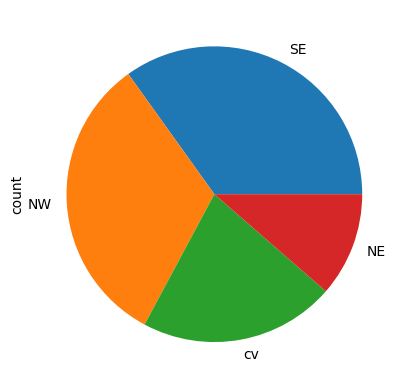

In [34]:
df['cbwd'].value_counts().plot.pie()

(43824, 8)

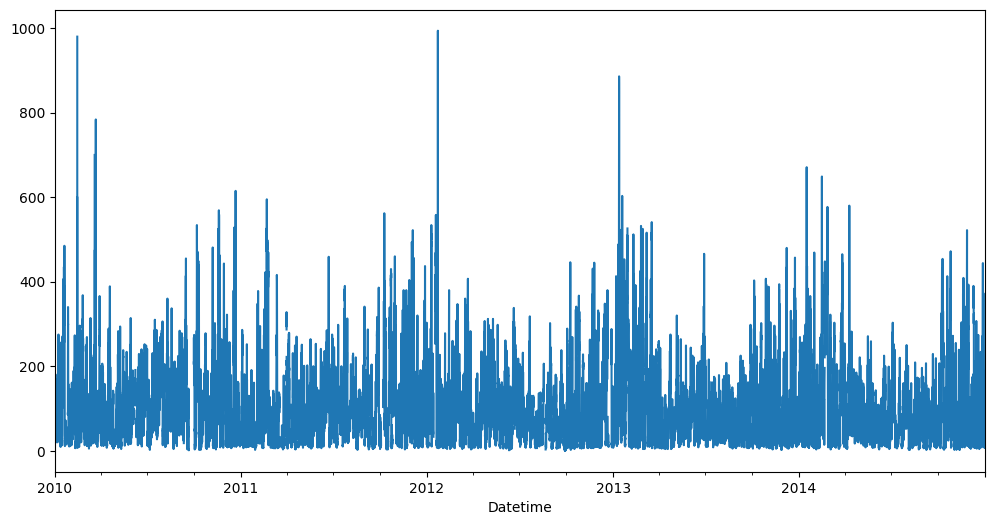

In [29]:
Target ='pm2.5'
df[Target].plot(figsize=(12,6))
df.shape

## 데이터 정제- 누락데이터 처리, 카테고리-> 수치형으로 변환

In [ ]:
df = df.dropna()

In [41]:
df_xy = pd.get_dummies(df)
df_xy.info()
df_xy.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pm2.5    41757 non-null  float64
 1   DEWP     41757 non-null  int64  
 2   TEMP     41757 non-null  float64
 3   PRES     41757 non-null  float64
 4   Iws      41757 non-null  float64
 5   Is       41757 non-null  int64  
 6   Ir       41757 non-null  int64  
 7   cbwd_NE  41757 non-null  bool   
 8   cbwd_NW  41757 non-null  bool   
 9   cbwd_SE  41757 non-null  bool   
 10  cbwd_cv  41757 non-null  bool   
dtypes: bool(4), float64(4), int64(3)
memory usage: 2.7 MB


(41757, 11)

### 전처리- RNN 모델로 학습시킬 수 있도록 x,y를 만들기(교사학습)
- 무엇으로 무엇을 예측할 것인가
- 지난 7일간의 기상 데이터로 내일 24시간 동안의 데이터 예측
- 7일 24시간 11개 특징 -> 1일 24시간 * 1개 (pm2.5)

In [43]:
sequence_x = 7 * 24
sequence_y = 24
len(df_xy)
df_xy.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
Datetime,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,False,False,True,False
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,False,False,True,False
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,False,False,True,False
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,False,False,True,False
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,False,False,True,False


In [45]:
m = len(df_xy) - (sequence_x + sequence_y) + 1
feature_k = df_xy.shape[-1]
(m,sequence_x, feature_k), (m,sequence_y,1)

((41566, 168, 11), (41566, 24, 1))

In [46]:
data_x = np.zeros((m, sequence_x, feature_k),np.float32)
data_y = np.zeros((m, sequence_y, 1),np.float32)

In [48]:
df_arr = np.array(df_xy)
for i in range(m):
    data_x[i] = df_arr[i:i + sequence_x]
    data_y[i] = df_arr[i + sequence_x:i + sequence_x + sequence_y,0:1]

In [51]:
### 정규화
from sklearn.preprocessing import MinMaxScaler

In [52]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [59]:
data_x_2d = np.reshape(data_x,[-1, feature_k])
scaler_x = scaler_x.fit(data_x_2d)
data_x_2d = scaler_x.transform(data_x_2d)
data_x = np.reshape(data_x_2d, [m, sequence_x, feature_k])
data_x.shape, data_x.min(), data_x.max()

((41566, 168, 11), np.float32(0.0), np.float32(1.0))

In [61]:
scaler_y = scaler_y.fit(data_y.reshape(-1,1))
data_y = scaler_y.transform(data_y.reshape(-1,1)).reshape(m,sequence_y,1)
data_y.shape, data_y.min(), data_y.max()


((41566, 24, 1), np.float32(0.0), np.float32(0.99999994))

In [63]:
### 학습용/테스트용 분리
m_train = 1000
m_test = 1000
x_train = data_x[:m_train]
x_test = data_y[m_train:m_train + m_test]
y_train = data_y[:m_train]
y_test = data_y[m_train:m_train + m_test]
x_train.shape, x_test.shape
y_train.shape, y_test.shape

((1000, 24, 1), (1000, 24, 1))

- 3차원 시계열 데이터 시퀀스 길이 7일 + 24시간 = 168시간
- 커널의 길이 7, 스트라이드 3, 정보 인코딩 32 output
- convolution 1d
- RNN - 셀선택: RNN, <GRU>, LSTM, 인코딩 32output
- RNN의 마지막 시퀀스 output >FC> 24개의 미세먼지 농도 예측
